In [128]:
"""
Docstring for nyc-insprction.ipynb
"""

import pandas as pd

data = pd.read_csv('data/43nn-pn8j.csv')
data.head()

/var/folders/_m/rpxkq7s94wnfkjc8pwcmwfwh0000gn/T/ipykernel_40551/1159322106.py:7: DtypeWarning: Columns (0: phone) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/43nn-pn8j.csv')


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,location
0,50181054,YOU FU HAPPY BREAKFAST INC.,Queens,40-33,MAIN STREET,11354.0,6469197789,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.758653,-73.829679,407.0,20.0,85300.0,4113543.0,4.050190e+09,QN22,POINT (-73.829678700764 40.758653213776)
1,50166448,ZOA INC,Manhattan,2036,2 AVENUE,10029.0,3472794247,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.789778,-73.943035,111.0,8.0,17000.0,1052732.0,1.016760e+09,MN33,POINT (-73.943034703266 40.789778461885)
2,50165784,AYAT,Brooklyn,274,36 STREET,11232.0,7188312585,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.655881,-74.007053,307.0,38.0,200.0,3010304.0,3.006950e+09,BK32,POINT (-74.007053154613 40.655880716657)
3,50180949,QATRA COFFEE CORP.,Brooklyn,100,BUSHWICK AVENUE,11206.0,9295133149,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.711845,-73.940642,301.0,34.0,49500.0,3323056.0,3.027900e+09,BK90,POINT (-73.940641519189 40.711845247032)
4,50162955,KID,Manhattan,157,WEST 18 STREET,10011.0,6468646504,NaN,1900-01-01T00:00:00.000,NaN,...,NaN,40.740519,-73.996575,104.0,3.0,8700.0,1014713.0,1.007940e+09,MN13,POINT (-73.996575381015 40.740518662562)


## Grade investigation

Investigation of available grades, scores and how ther distribute across the dataset

According to https://www.nycrestaurantgrades.com/grading-info we have the following possible grades sand scores:
- __Grade A (0-13 points)__: Excellent food safety practices. Restaurant meets highest standards with minimal violations.
- __Grade B (14-27 points)__: Good food safety practices with some violations that need correction.
- __Grade C (28+ points)__: Poor food safety practices. Significant violations present requiring immediate attention.
- __Grade Z (Grade Pending)__:Restaurant is awaiting a re-inspection or tribunal hearing. Restaurants have the right to contest violations before receiving a final grade.
- __Grade P (Grade Pending on Re-opening)__: Issued when a restaurant reopens after being closed. A new inspection will be conducted within 14 days.
- __Grade N (Not Yet Graded)__: New restaurant that hasn't received its first grade or recently opened location.

In [129]:
data.grade.value_counts()

grade
A    33003
B     6237
C     4663
N     3180
Z     1647
P      304
Name: count, dtype: int64

In [130]:
# get threshold for each grade
for grade in data.grade.value_counts().keys().to_list():
    subset = data[data['grade']==grade]
    print(f"Max for {grade}:",subset.score.max())
    print(f"Min for {grade}:",subset.score.min())

Max for A: 43.0
Min for A: 0.0
Max for B: 102.0
Min for B: 0.0
Max for C: 154.0
Min for C: 0.0
Max for N: 203.0
Min for N: 0.0
Max for Z: 108.0
Min for Z: 0.0
Max for P: 27.0
Min for P: 0.0


It seems we have some outliers in every class. Lets investigate those

In [131]:
grades = {
    'A':{'min':0,'max':13},
    'B':{},
    'C':{},
    'N':{},
    'Z':{},
    'P':{}
}
data[(data['grade'] == 'A') & ((data['score'] > 13) | (data['score'].isnull()))][['grade','score']].values

array([['A', 16.0],
       ['A', 27.0],
       ['A', 27.0],
       ['A', 19.0],
       ['A', 43.0],
       ['A', 43.0],
       ['A', nan]], dtype=object)

In [132]:
# 1. Define the official NYC grading rules
grade_rules = {
    'A': {'min': 0,  'max': 13},
    'B': {'min': 14, 'max': 27},
    'C': {'min': 28, 'max': float('inf')}
}

print(f"{'GRADE':<10} | {'ISSUE':<20} | {'COUNT'}")
print("-" * 45)

for grade, limits in grade_rules.items():
    grade_mask = (data['grade'] == grade)
    
    out_of_bounds = data[grade_mask & ((data['score'] < limits['min']) | (data['score'] > limits['max']))]
    missing_scores = data[grade_mask & (data['score'].isnull())]
    
    if not out_of_bounds.empty:
        print(f"{grade:<10} | Out of Range        | {len(out_of_bounds)}")
        print(out_of_bounds[['camis','grade','score']].values)
        
    if not missing_scores.empty:
        print(f"{grade:<10} | Missing Score       | {len(missing_scores)}")
        print(missing_scores[['camis','grade','score']].values)

GRADE      | ISSUE                | COUNT
---------------------------------------------
A          | Out of Range        | 6
[[50104160 'A' 16.0]
 [50050528 'A' 27.0]
 [50050528 'A' 27.0]
 [50103178 'A' 19.0]
 [40586834 'A' 43.0]
 [40586834 'A' 43.0]]
A          | Missing Score       | 1
[[40873175 'A' nan]]
B          | Out of Range        | 34
[[50000228 'B' 0.0]
 [50084694 'B' 33.0]
 [50142027 'B' 31.0]
 [41532937 'B' 39.0]
 [50053086 'B' 46.0]
 [50053086 'B' 46.0]
 [50064218 'B' 33.0]
 [50100520 'B' 46.0]
 [50000310 'B' 102.0]
 [41532937 'B' 39.0]
 [50065192 'B' 33.0]
 [50065192 'B' 33.0]
 [50100520 'B' 46.0]
 [50091299 'B' 28.0]
 [40395597 'B' 35.0]
 [50047742 'B' 5.0]
 [50088385 'B' 38.0]
 [50000310 'B' 102.0]
 [40395597 'B' 35.0]
 [50121060 'B' 40.0]
 [50096780 'B' 5.0]
 [50088385 'B' 38.0]
 [50130469 'B' 66.0]
 [41713624 'B' 34.0]
 [50138058 'B' 32.0]
 [50138058 'B' 32.0]
 [50088385 'B' 38.0]
 [50043790 'B' 39.0]
 [50084694 'B' 33.0]
 [50064218 'B' 33.0]
 [50142027 'B' 31.0]
 [

It seems that we have some outliers in here. We need to take care of the identified outliers. We need to
- Relabel the outliers with correct label
- Z labels have score values, but according to descriptions restaurant is waiting for grade attribuition.
- N labels have score values despite N meaningn "Not Graded Yet". Should we replace this with the correct grade?
- P labels have score values despite being "not graded yet

This suggest that we should rely on the score to create our risk category instead of using the scores.

Z, N, and P grades represent administrative states rather than final food safety outcomes. Since inspection scores are available for these records, we derive the risk category directly from inspection scores instead of using the grade field. This ensures consistency and avoids incorporating temporary grade statuses into the predictive target.

## Creation of risk_category label

Create this category based on score instead of grade due to score outliers and administrative labels with score

In [133]:
def create_risk(score):
    if score <= 13:
        return "Low"
    elif score <= 27:
        return "Moderate"
    elif score > 27:
        return "High"
    else:
        None

data['risk_category'] = data['score'].apply(create_risk)
data.risk_category.value_counts(dropna=False)

risk_category
Low         36565
High        32271
Moderate    25184
NaN          5980
Name: count, dtype: int64

We will drop everything that doesn't have a risk_category associated

In [134]:
data=data.dropna(subset=['risk_category'])
data.risk_category.value_counts(dropna=False)

risk_category
Low         36565
High        32271
Moderate    25184
Name: count, dtype: int64

## Violation code inspection

Inspect violation code

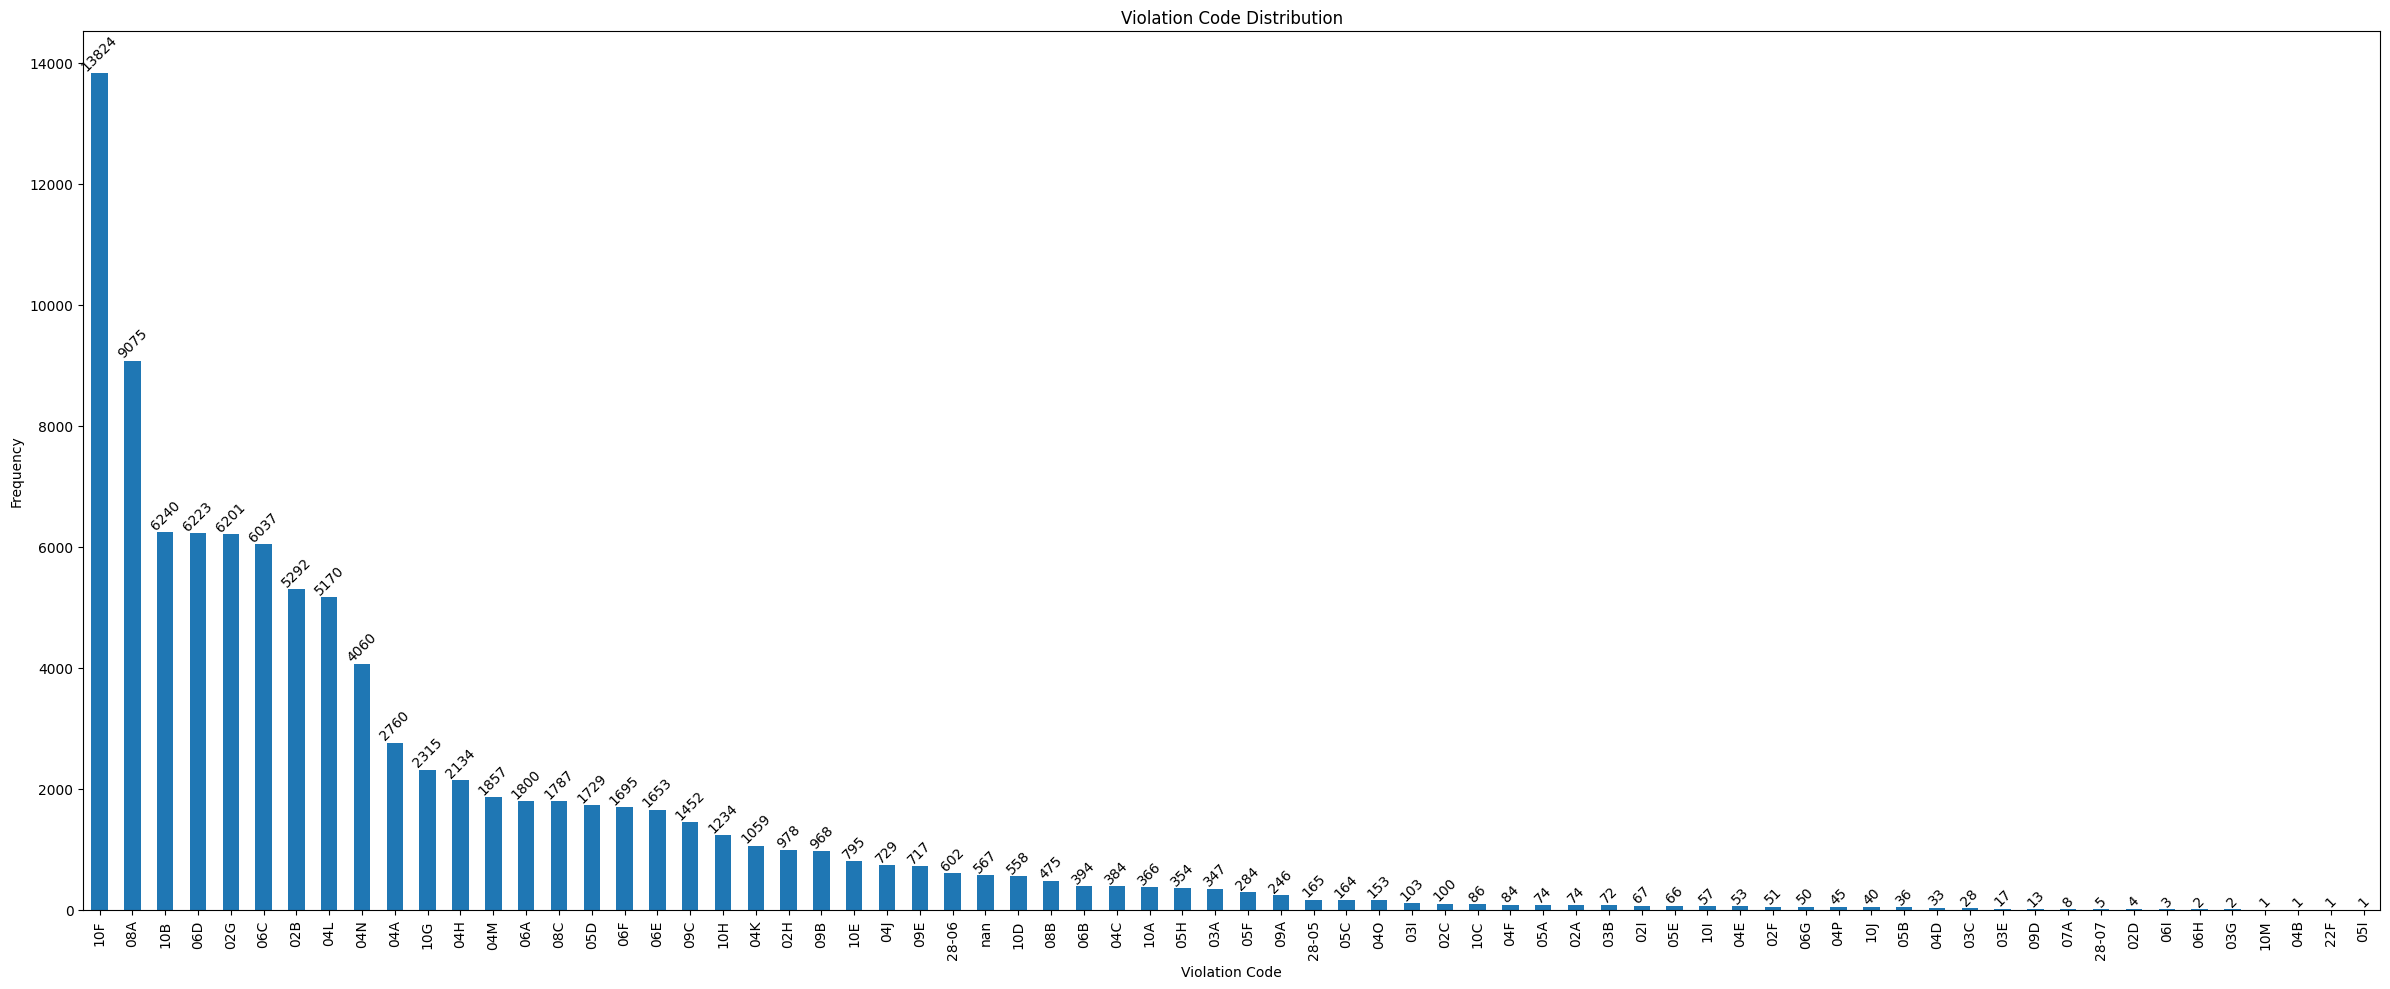

In [135]:
import matplotlib.pyplot as plt

ax = data.violation_code.value_counts(dropna=False).plot.bar(
    figsize=(24,10),
    title='Violation Code Distribution'
)

# Add value labels
for i, v in enumerate(data.violation_code.value_counts(dropna=False)):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10,rotation=45)

plt.xticks(rotation=90)
plt.xlabel("Violation Code")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Since violation description is based on the violation code - for example the majority of 10F violation codes has the same text description, we can drop violation description

## Action inspection

Inspect action column distribuition. Despite being a textual col it seems to be able to be encoded

In [136]:
data.action.value_counts(dropna=False)

action
Violations were cited in the following area(s).                                                                                       88939
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.     3548
Establishment re-opened by DOHMH.                                                                                                       627
No violations were recorded at the time of this inspection.                                                                             488
Establishment re-closed by DOHMH.                                                                                                       418
Name: count, dtype: int64

## Inspection date 

Inspect inspeciton date column. We might have some outliers - It seems that removing null risk_categories removed dates with 1900

In [137]:
print('Inspection date max:',data.inspection_date.max())
print('Inspection date min:',data.inspection_date.min())

converted_dates = pd.to_datetime(data['inspection_date'], errors='coerce').reset_index(drop=True)
data['year']=converted_dates.dt.year
data['month']=converted_dates.dt.month
data['day']=converted_dates.dt.day
data.head()

Inspection date max: 2026-02-04T00:00:00.000
Inspection date min: 2008-12-30T13:59:00.000


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,council_district,census_tract,bin,bbl,nta,location,risk_category,year,month,day
8,41543970,PAUSE CAFE,Manhattan,3,CLINTON SREET,NaN,2126775415,Middle Eastern,2024-12-17T00:00:00.000,Violations were cited in the following area(s).,...,NaN,NaN,NaN,1.000000e+00,NaN,NaN,Moderate,2025.0,1.0,6.0
11,50108715,JUFU GARDEN,Manhattan,68,EAST BROADWAY,10002.0,2122748659,Chinese,2025-11-24T00:00:00.000,Violations were cited in the following area(s).,...,1.0,800.0,1003506.0,1.002810e+09,MN27,POINT (-73.995206032255 40.713628140681),Moderate,2025.0,4.0,29.0
12,50122846,IPIZZANY,Manhattan,621,2 AVENUE,10016.0,6465967071,Pizza,2023-10-12T00:00:00.000,Establishment re-opened by DOHMH.,...,2.0,7000.0,1020129.0,1.009140e+09,MN20,POINT (-73.97596120472 40.744677255478),Low,2025.0,11.0,3.0
18,41656924,TENZAN,Manhattan,988990,2 AVENUE,NaN,2129805900,Japanese,2023-11-21T00:00:00.000,Violations were cited in the following area(s).,...,NaN,NaN,NaN,1.000000e+00,NaN,NaN,Low,2024.0,6.0,15.0
19,50006470,DYLAN'S CANDY BAR,Queens,NaN,JFK AIRPORT,11430.0,7188783029,Other,2019-05-16T00:00:00.000,Violations were cited in the following area(s).,...,NaN,NaN,NaN,NaN,NaN,NaN,Low,2023.0,11.0,28.0


In [138]:
# To remove
data.record_date.value_counts(dropna=False)

record_date
2026-02-06T06:00:14.000    93973
2026-02-06T06:00:16.000       47
Name: count, dtype: int64

In [139]:
data.boro.value_counts(dropna=False)

boro
Manhattan        34539
Brooklyn         24079
Queens           23401
Bronx             8722
Staten Island     3261
0                   18
Name: count, dtype: int64

In [140]:
data=data[data.boro!='0']
data.boro.value_counts(dropna=False)

boro
Manhattan        34539
Brooklyn         24079
Queens           23401
Bronx             8722
Staten Island     3261
Name: count, dtype: int64

## Group by Inspection

We need to groupby inspection and make (camis for example) and make dummy cols out of violation codes. 

In [147]:
# remove elements without violation code
data = data.dropna(subset='violation_code')

violation_code_dummies = pd.get_dummies(data['violation_code'], prefix='code', dtype=int)
cols_for_group_by = ['camis','dba','boro','inspection_date','building','street','zipcode','cuisine_description','risk_category']
data_with_dummies=pd.concat([data[cols_for_group_by],violation_code_dummies],axis=1)
final=data_with_dummies.groupby(cols_for_group_by, as_index=False).sum()
final.head()

,camis,dba,boro,inspection_date,building,street,zipcode,cuisine_description,risk_category,code_02A,...,code_10F,code_10G,code_10H,code_10I,code_10J,code_10M,code_22F,code_28-05,code_28-06,code_28-07
0,30075445,MORRIS PARK BAKE SHOP,Bronx,2023-01-31T00:00:00.000,1007,MORRIS PARK AVENUE,10462.0,Bakery Products/Desserts,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
1,30191841,D.J. REYNOLDS,Manhattan,2024-11-20T00:00:00.000,351,WEST 57 STREET,10019.0,Irish,Moderate,0,...,1,0,0,0,0,0,0,0,0,0
2,40356483,WILKEN'S FINE FOOD,Brooklyn,2022-01-24T00:00:00.000,7114,AVENUE U,11234.0,Sandwiches,Low,0,...,0,0,0,0,0,0,0,0,0,0
3,40356483,WILKEN'S FINE FOOD,Brooklyn,2022-08-03T00:00:00.000,7114,AVENUE U,11234.0,Sandwiches,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
4,40356483,WILKEN'S FINE FOOD,Brooklyn,2023-11-16T00:00:00.000,7114,AVENUE U,11234.0,Sandwiches,High,0,...,0,0,0,0,0,0,0,0,0,0


Watch out for dummy variable trap!

## Inspection date encoding

In [148]:
final.inspection_date=final.inspection_date.astype('datetime64[s]')
final.year=final.inspection_date.dt.year
final.month=final.inspection_date.dt.month
final.day_of_week = final.inspection_date.dt.dayofweek # 0=Monday
final.is_weekend = (final.inspection_date.dt.dayofweek >= 5).astype(int)

/var/folders/_m/rpxkq7s94wnfkjc8pwcmwfwh0000gn/T/ipykernel_40551/2483930676.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  final.year=final.inspection_date.dt.year
/var/folders/_m/rpxkq7s94wnfkjc8pwcmwfwh0000gn/T/ipykernel_40551/2483930676.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  final.month=final.inspection_date.dt.month
/var/folders/_m/rpxkq7s94wnfkjc8pwcmwfwh0000gn/T/ipykernel_40551/2483930676.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  final.day_of_week = final.inspection_date.dt.dayofweek # 0=Monday
/var/folders/_m/rpxkq7s94wnfkjc8pwcmwfwh0000gn/T/ipykernel_40551/2483930676.py:5: UserWarning: Pandas doesn't

## Zipcode inspection

We can fill zipcodes via geopy by using street name and boro

In [143]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# 1. Initialize locator
geolocator = Nominatim(user_agent="address_zip_lookup")

# 2. Add Rate Limiter (1 request per second for free tier)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_zip_from_address(address_str):
    print(f'Boro+Address: {address_str}')
    try:
        location = geocode(address_str)
        print(f'Extracted location: {location}')
    except Exception:
        return None
    return None

In [144]:
mask = final['zipcode'].isna()
final[mask].apply(
    lambda x: get_zip_from_address(f"{x['boro']}, {x['street']}"), 
    axis=1
)

Boro+Address: nan, nan
Extracted location: 南县, 南洲镇, 南县, 湖南省, 中国


Series([], dtype: float64)

In [145]:
for a,b in final['zipcode'].value_counts(dropna=False).items():
    print(a,b)

10003.0 1235
10019.0 1184
10001.0 1174
10013.0 1140
10002.0 1062
11354.0 1058
10036.0 1043
11201.0 935
10016.0 911
10012.0 905
11372.0 877
11220.0 859
10018.0 824
10014.0 816
10022.0 792
10011.0 792
11211.0 771
11101.0 746
11215.0 654
10017.0 633
11385.0 624
11373.0 617
11368.0 610
10009.0 601
11103.0 541
11217.0 540
11209.0 537
11355.0 525
11237.0 522
11226.0 493
10025.0 490
11214.0 486
11377.0 474
11222.0 472
10010.0 467
11238.0 458
10458.0 454
11432.0 450
10029.0 442
11216.0 437
11375.0 434
10038.0 422
10023.0 409
10028.0 407
11106.0 403
10024.0 399
10314.0 390
11206.0 370
10467.0 363
11249.0 363
11234.0 362
10462.0 358
10461.0 358
11223.0 345
10065.0 333
11218.0 331
10021.0 326
11235.0 326
11221.0 326
11203.0 316
10007.0 314
11225.0 314
11229.0 313
11204.0 308
11207.0 306
11205.0 305
11231.0 304
11419.0 296
11358.0 295
10027.0 295
11105.0 292
11361.0 288
10128.0 286
10306.0 276
11236.0 275
10004.0 273
10033.0 266
11435.0 263
10463.0 260
11212.0 256
10031.0 256
11208.0 255
10032.0 2

In [149]:
final

,camis,dba,boro,inspection_date,building,street,zipcode,cuisine_description,risk_category,code_02A,...,code_10F,code_10G,code_10H,code_10I,code_10J,code_10M,code_22F,code_28-05,code_28-06,code_28-07
0,30075445,MORRIS PARK BAKE SHOP,Bronx,2023-01-31,1007,MORRIS PARK AVENUE,10462.0,Bakery Products/Desserts,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
1,30191841,D.J. REYNOLDS,Manhattan,2024-11-20,351,WEST 57 STREET,10019.0,Irish,Moderate,0,...,1,0,0,0,0,0,0,0,0,0
2,40356483,WILKEN'S FINE FOOD,Brooklyn,2022-01-24,7114,AVENUE U,11234.0,Sandwiches,Low,0,...,0,0,0,0,0,0,0,0,0,0
3,40356483,WILKEN'S FINE FOOD,Brooklyn,2022-08-03,7114,AVENUE U,11234.0,Sandwiches,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
4,40356483,WILKEN'S FINE FOOD,Brooklyn,2023-11-16,7114,AVENUE U,11234.0,Sandwiches,High,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55000,50180658,LE BISTROQUET,Manhattan,2026-01-13,50,WEST 22 STREET,10010.0,French,High,0,...,1,0,0,0,0,0,0,0,0,0
55001,50180662,GREKA BY MONTUNO COFFEE,Bronx,2026-01-21,15,CANAL PLACE,10451.0,Coffee/Tea,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
55002,50180709,DOUBLE KNOT,Manhattan,2026-01-22,1251,AVENUE OF THE AMERICAS,10020.0,Japanese,Low,0,...,0,0,0,0,0,0,0,0,0,0
55003,50180786,DOLLYS SWING & DIVE,Brooklyn,2026-01-28,146,WYTHE AVENUE,11249.0,American,Moderate,0,...,0,0,0,0,0,0,0,0,0,0


it seems after all this preprocessing there are no more null zipcodes! Explain the approach intended 

also the same with cusine_description!

In [150]:
cuisine_dummies = pd.get_dummies(final['cuisine_description'], prefix='cuisine', dtype=int) # drop first because of dummy variable trap?
boro_dummies = pd.get_dummies(final.boro,prefix='boro',dtype=int)
zipcode_dummies = pd.get_dummies(final.zipcode,prefix='zipcode',dtype=int)
f = pd.concat([final,cuisine_dummies,boro_dummies,zipcode_dummies],axis=1)
f

,camis,dba,boro,inspection_date,building,street,zipcode,cuisine_description,risk_category,code_02A,...,zipcode_11432.0,zipcode_11433.0,zipcode_11434.0,zipcode_11435.0,zipcode_11436.0,zipcode_11691.0,zipcode_11692.0,zipcode_11693.0,zipcode_11694.0,zipcode_11697.0
0,30075445,MORRIS PARK BAKE SHOP,Bronx,2023-01-31,1007,MORRIS PARK AVENUE,10462.0,Bakery Products/Desserts,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
1,30191841,D.J. REYNOLDS,Manhattan,2024-11-20,351,WEST 57 STREET,10019.0,Irish,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
2,40356483,WILKEN'S FINE FOOD,Brooklyn,2022-01-24,7114,AVENUE U,11234.0,Sandwiches,Low,0,...,0,0,0,0,0,0,0,0,0,0
3,40356483,WILKEN'S FINE FOOD,Brooklyn,2022-08-03,7114,AVENUE U,11234.0,Sandwiches,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
4,40356483,WILKEN'S FINE FOOD,Brooklyn,2023-11-16,7114,AVENUE U,11234.0,Sandwiches,High,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55000,50180658,LE BISTROQUET,Manhattan,2026-01-13,50,WEST 22 STREET,10010.0,French,High,0,...,0,0,0,0,0,0,0,0,0,0
55001,50180662,GREKA BY MONTUNO COFFEE,Bronx,2026-01-21,15,CANAL PLACE,10451.0,Coffee/Tea,Moderate,0,...,0,0,0,0,0,0,0,0,0,0
55002,50180709,DOUBLE KNOT,Manhattan,2026-01-22,1251,AVENUE OF THE AMERICAS,10020.0,Japanese,Low,0,...,0,0,0,0,0,0,0,0,0,0
55003,50180786,DOLLYS SWING & DIVE,Brooklyn,2026-01-28,146,WYTHE AVENUE,11249.0,American,Moderate,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
f.drop(['camis','dba','boro','inspection_date','building','street','zipcode','cuisine_description'],axis=1)

,risk_category,code_02A,code_02B,code_02C,code_02D,code_02F,code_02G,code_02H,code_02I,code_03A,...,zipcode_11432.0,zipcode_11433.0,zipcode_11434.0,zipcode_11435.0,zipcode_11436.0,zipcode_11691.0,zipcode_11692.0,zipcode_11693.0,zipcode_11694.0,zipcode_11697.0
0,Moderate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Moderate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Low,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Moderate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,High,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55000,High,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55001,Moderate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55002,Low,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55003,Moderate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
